In [69]:
import SALib
import numpy as np
import pandas as pd
import re, os
import time
import matplotlib.pyplot as plt
from adjustText import adjust_text

Colorblind-friendly palette

In [79]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [80]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [81]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


BRICK parameters are the same for all scenarios because they are calibrated in hindcast.

In [82]:
brickdir = "https://zenodo.org/record/6626335/files/parameters_subsample_sneasybrick.csv"
dfPB = pd.read_csv(brickdir)

SSP-RCP scenarios and a dictionary to hold the sensitivity results from Method of Morris:

In [83]:
surge_option = 0
scenarios = [(1,26),(2,45),(4,60),(5,85)]
dfSi = {scen : None for scen in scenarios}

Directories where all the BRICK-CIAM results are, for all the different SSP-RCP scenarios.

In [103]:
for (ssp, rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    dfSC = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfSC = dfSC.join(pd.read_csv(bothdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv"))
    dfPC = pd.read_csv(bothdir+"/trials_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv",
                       names = ["movefactor","dvbm","vslel","vslmult","wvel","wvpdl"], header=0)

    tmp = dfPB.iloc[dfSC.brickEnsInd]
    tmp.reset_index(inplace=True, drop=True)
    dfP = pd.concat([tmp,dfPC], axis=1)
        
    n_ensemble, n_parameter = dfP.shape
    mins = list(dfP.min())
    maxs = list(dfP.max())
    bounds = [[mins[i],maxs[i]] for i in range(n_parameter)]

    problem = {"num_vars" : n_parameter,
               "names" : list(dfP.columns),
               "bounds" : bounds}

    X = np.array(dfP)[:986,:]
    Y = np.array(dfSC.npv)[:986]
    dfSi[(ssp,rcp)] = pd.DataFrame(SALib.analyze.morris.analyze(problem, X, Y, print_to_console=False))
    dfSi[(ssp,rcp)]["dist"] = np.sqrt(dfSi[(ssp,rcp)].mu_star**2 + dfSi[(ssp,rcp)].sigma**2)
    

* dvbm = FUND value of OECD dryland per Darwin et al 1995 converted from $1995 ($2010M per sqkm) (5.376)
* wvel = income elasticity of wetland value (1.16) (Brander et al, 2006)
* movefactor = Cost to relocate mobile capital as a fraction of asset value (0.1)
* vslel = Elasticity of vsl (0.5) (only used for endogenous calculation of vsl)
* vslmult = multiplier on USA GDP (216)(only used for endogenous calculation of vsl)
* wvpdl = Population density elasticity of wetland value (0.47) (Brander et al, 2

### sorted by mu_star

In [189]:
top = 8
for scen in scenarios:
    print("================================")
    print(scen)
    print(dfSi[scen].sort_values(by="mu_star", ascending=False)[["names","mu_star","sigma"]][:top])

(1, 26)
                  names       mu_star        sigma
52                 dvbm  20967.342562  4573.128103
55                 wvel   5879.730739  5417.719416
25      CO2_diffusivity   5521.745552  6336.531167
10        rho_greenland   5421.156006  6494.989944
13           alpha0_CO2   5377.004894  6364.049920
28  climate_sensitivity   5189.764296  6020.111551
51           movefactor   4920.722021  6066.460217
2           sd_glaciers   4763.421734  5636.844177
(2, 45)
              names       mu_star         sigma
52             dvbm  26370.773888   5356.556643
55             wvel  17659.023327   6314.389764
53            vslel  10300.679502  12282.423727
56            wvpdl   9539.593454  10957.693149
7   rho_temperature   9135.686743  10989.637577
38  antarctic_gamma   9047.973856  12770.985154
14            CO2_0   8977.089476  10765.111325
5           sd_gmsl   8440.419013  10173.117591
(4, 60)
                names       mu_star        sigma
52               dvbm  26666.784299 

### sorted by distance (mustar^2 + sigma^2)

In [188]:
top = 8
for scen in scenarios:
    print("================================")
    print(scen)
    print(dfSi[scen].sort_values(by="dist", ascending=False)[["names","mu_star","sigma","dist"]][:top])

(1, 26)
                  names       mu_star        sigma          dist
52                 dvbm  20967.342562  4573.128103  21460.264555
10        rho_greenland   5421.156006  6494.989944   8460.131608
25      CO2_diffusivity   5521.745552  6336.531167   8404.837962
13           alpha0_CO2   5377.004894  6364.049920   8331.465238
55                 wvel   5879.730739  5417.719416   7995.180875
28  climate_sensitivity   5189.764296  6020.111551   7948.295196
51           movefactor   4920.722021  6066.460217   7811.238364
2           sd_glaciers   4763.421734  5636.844177   7379.986375
(2, 45)
              names       mu_star         sigma          dist
52             dvbm  26370.773888   5356.556643  26909.299777
55             wvel  17659.023327   6314.389764  18754.002851
53            vslel  10300.679502  12282.423727  16030.032152
38  antarctic_gamma   9047.973856  12770.985154  15651.322394
56            wvpdl   9539.593454  10957.693149  14528.416376
7   rho_temperature   9135.

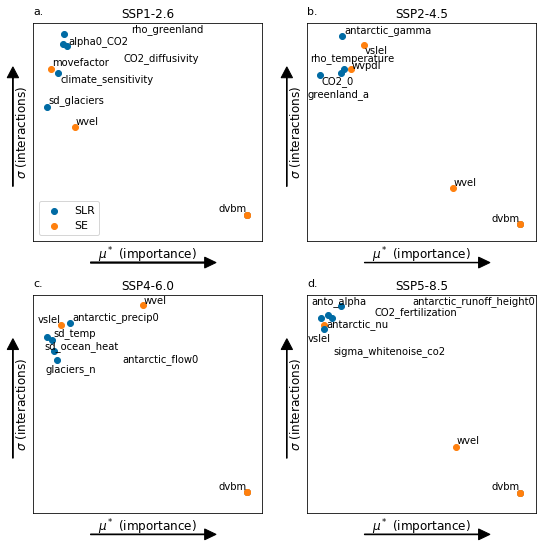

In [187]:
#top = len(dfSi[(1,26)])
top = 8
scen_labels = ["SSP1-2.6","SSP2-4.5","SSP4-6.0","SSP5-8.5"]
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]
colors = {"SLR":"C0", "SE":"C1"}

fig, ax = plt.subplots(2,2,figsize=(9,9))
fig.subplots_adjust(hspace=.25,wspace=0.2)
for s in range(len(scenarios)):
    scen = scenarios[s]
    row,col = int(s/2), s%2
    names  = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["names"])
    mustar = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["mu_star"])
    sigma  = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["sigma"])
    # for the legend only
    ax[row][col].scatter(np.log10(mustar[0]),np.log10(sigma[0]),color=colors["SLR"],label="SLR")
    ax[row][col].scatter(np.log10(mustar[0]),np.log10(sigma[0]),color=colors["SE"],label="SE")
    for i in range(top):
        color = colors["SE"] if (names[i] in ciam_params) else colors["SLR"]
        ax[row][col].scatter(np.log10(mustar[i]),np.log10(sigma[i]), color=color)
    ax[row][col].set_title(scen_labels[s], fontsize=12);
    ax[row][col].set_xticks([]); ax[row][col].set_yticks([])
    xlims = ax[row][col].get_xlim(); xrange = np.diff(xlims)[0]
    ylims = ax[row][col].get_ylim(); yrange = np.diff(ylims)[0]
    ax[row][col].text(xlims[0], ylims[1]+0.04*yrange, panels[s], fontsize=11)
    annotations = []
    for i in range(top):
        annotations.append(ax[row][col].text(np.log10(mustar[i]),np.log10(sigma[i]),names[i]))
    adjust_text(annotations,x=np.log10(mustar),y=np.log10(sigma),ax=ax[row][col],expand_align=(1.2,1.2))
    
    bbox_props = dict(boxstyle="rarrow, pad=0.2", fc="white", ec="black", lw=1)
    ax[row][col].set_xlabel("$\\mu^*$ (importance)", fontsize=12);
    ax[row][col].set_ylabel("$\\sigma$ (interactions)", fontsize=12);
    ax[row][col].arrow(xlims[0]+0.25*xrange, ylims[0]-0.1*yrange, 0.5*xrange, 0,
                       head_width=0.05*yrange, head_length=0.05*xrange, fc='k', ec='k', clip_on=False)
    ax[row][col].arrow(xlims[0]-0.09*xrange, ylims[0]+0.25*yrange, 0, 0.5*yrange,
                       head_width=0.05*xrange, head_length=0.05*yrange, fc='k', ec='k', clip_on=False)
    if s==0:
        ax[row][col].legend(fontsize=11,loc="lower left")
fig.savefig(plotdir+"/sensitivity_ssprcp.pdf", bbox_inches='tight');
